# Random Forest Classifier and Regressor

En este notebook se usan los métodos de árboles y de *random forest* sobre los datasets proporcionados para realizar predicciones de clasificación y regresión.

### Tabla de contenidos

- [Carga del dataset](#Carga-del-dataset)
- [Análisis descriptivo de los datos](#Análisis-descriptivo-de-los-datos)
  - [Comentario sobre normalización](#Comentario-sobre-normalización)
- [Selección de variables predictoras y objetivo](#Selección-de-variables-predictoras-y-objetivo)
- [Tratamiento de missing values](#Tratamiento-de-missing-values)
- [Conjuntos de entrenamiento y validación](#Conjuntos-de-entrenamiento-y-validación)
- [Entrenamiento y predicción](#Entrenamiento-y-predicción)
  - [Árboles de decisión](#Árboles-de-decisión)
  - [Random Forest](#Random-Forest)
- [Conclusiones](#Conclusiones)
- [Apéndices](#Apéndices)
  - [Estudio de relación de variables](#Estudio-de-relación-de-variables)
    - [Variables de calendario](#Variables-de-calendario)
    - [Variables de meteorología](#Variables-de-meteorología)
  - [Clasificación por regresión](#Clasificación-por-regresión)
  - [Generación de PDFs](#Generación-de-PDFs)

In [1]:
### Funciones auxiliares

import datetime
import errno
import math
import os
import sys

# Función para validar que el fichero existe
def assert_fichero(nombre):
    if (not os.path.isfile(nombre)):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), nombre)
        
# Función para imprimir mensajes por la salida de error
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

# Función para representar la correlación entre variables
!pip install -q seaborn
import seaborn as sns
def dibujar_correlacion_de_variables(df, variables):
    sns.pairplot(df[variables], diag_kind='kde')

# Calcula la recta de ajuste a los juegos de datos X e Y
from sklearn.linear_model import LinearRegression
def recta_ajuste(X, Y):
    """
    :param X: serie de valores de x
    :param Y: serie de valores de y
    :return: (X, Valores Y de la recta de ajuste)
    """
    reg = LinearRegression().fit(X.reshape(-1, 1), Y)
    
    x_recta = np.array([min(X), max(X)])
    return (x_recta, reg.predict(x_recta.reshape(-1, 1)), reg)

# Función para generar la gráfica de comparación de predicciones
import matplotlib.pyplot as plt
%matplotlib inline
def mostrar_grafica_comparacion_predicciones(Y_predict, Y_real, r2_score, tipo, title, mostrar=True, nombre_imagen=None):
    lw = 2 # Grosor de los elementos de la gráfica
    
    # Diagonal ó recta de ajuste perfecto
    diagonal = [min(Y_real), max(Y_real)]
    plt.plot(diagonal, diagonal, color='coral', lw=lw,
             linestyle='--', label='Ajuste perfecto')

    # Recta de mejor ajuste entre valores reales y valores predichos
    (x_ajuste, y_ajuste, reg) = recta_ajuste(Y_predict, Y_real)
    (pendiente, interseccion) = (reg.coef_[0], reg.intercept_)
    
    plt.plot(x_ajuste, y_ajuste, color='turquoise', lw=lw,
             linestyle='-.', label='Ajuste: {:.2f} + {:.2f}x'.format(interseccion, pendiente))
    
    # Representación de los valores predichos frente a los reales
    plt.scatter(Y_predict, Y_real, color='indigo', lw=lw, marker='.',
                label='{} (R\N{SUPERSCRIPT TWO} = {:.2f})'.format(tipo, r2_score))

    plt.xlabel('Valor predicción')
    plt.ylabel('Valor real')
    plt.title(title)
    plt.legend()
    
    if nombre_imagen:
        plt.savefig('{}.pdf'.format(nombre_imagen), format='pdf')
    
    if mostrar:
        plt.show()

# Función para representar la curva ROC
def representar_curva_roc(fpr, tpr, roc_auc, nombre_imagen=None):
    #plt.figure()
    lw = 2
    
    if isinstance(fpr, dict):
        for clave in fpr.keys():
            plt.plot(fpr[clave], tpr[clave], lw=lw,
                     label='Curva ROC %s (area = %0.2f)' % (clave, roc_auc[clave]))
    else:
        plt.plot(fpr, tpr, color='darkorange', lw=lw,
                 label='Curva ROC (area = %0.2f)' % roc_auc)
                     
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
        
    if nombre_imagen:
        plt.savefig('{}.pdf'.format(nombre_imagen), format='pdf')
    
    plt.show()

"""
Calcula y representa la curva ROC y el área bajo la curva (AUC)
Devuelve
roc_auc => área bajo la curva
fpr => tasa de falsos positivos
tpr => tasa de verdaderos positivos
"""
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def calcular_y_representar_curva_roc(esperado, predicho, mostrar=True, nombre_imagen=None):
    fpr, tpr, _ = roc_curve(esperado, predicho)
    roc_auc = auc(fpr, tpr)

    if mostrar:
        representar_curva_roc(fpr, tpr, roc_auc, nombre_imagen)
    
    return roc_auc, fpr, tpr

# Cálculo de errores de regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def calcular_errores_regresion(real, pred):
    mse  = mean_squared_error(real, pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(real, pred)
    r2   = r2_score(real, pred)
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Organización de features por importancia
import collections
def organizar_features_por_importancia(features, modelo):
    importancia_variables = modelo.feature_importances_
    
    features_con_orden = dict()
    for i in range(0, len(features)):
        features_con_orden[importancia_variables[i] * 100] = features[i]
        
    features_con_orden = collections.OrderedDict(reversed(sorted(features_con_orden.items())))
    
    # Se devuelve el diccionario invertido
    return {v: k for k, v in features_con_orden.items()}

### Carga del dataset

Para la carga del conjunto de datos se ha elegido el documento `hour.csv` frente a `day.csv`, dado que el segundo carece de la información por horas que será fundamental para predecir correctamente las ventas por hora, que es el propósito que se persigue.

In [2]:
import pandas as pd
import numpy as np

# Comprobación de que el fichero de datos está disponible
fichero_datos = 'hour.csv'
assert_fichero(fichero_datos)

# Carga del archivo como un DataFrame de Pantas con separador de columnas ','
df_raw = pd.read_csv(fichero_datos, sep=',')

# Muestra las primeras columnas del DataFrame cargado
df_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Análisis descriptivo de los datos

A continuación se realiza un breve repaso de las distintas variables que se recogen del conjunto de datos, basada en la información proporcionada por el documento `Readme.txt`

|Varible|Descripción|Valores|
|:-----:|:---------:|:-----:|
|`instant`|Es un índice sin carácter predictivo|Índice numérico|
|`dteday`|Fecha del año a la que corresponde el registro|`YYYY-mm-dd`|
|`season`|Variable categórica que indica la estación del año|`1`: primavera, `2`: verano, `3`: otoño y `4`: invierno|
|`yr`|Variable categórica que indica el año|`0`: 2011, `1`: 2012|
|`mnth`|Variable numérica para indicar el mes del año|`1`: Enero, ... , `12`: Diciembre|
|`hr`|Variable numérica para indicar la hora del día|`0`, ... , `23`|
|`holiday`|Variable binaria para indicar si es fiesta o no|`1`: Fiesta, `0`: No Fiesta|
|`weekday`|El día de la semana|`0`: Domingo, `1`: Lunes, ... , `6`: Sábado|
|`workingday`|Variable binaria para indicar si es un día laborable|`1`: Laborable, `0`: Festivo|
|`weathersit`|Variable categórica con el tiempo meteorológico del día|`1`: Soleado, `2`: Nublado, `3`: Lluvioso y `4`: Tormenta|
|`temp`|Variable continua con la temperatura en grados Celsius normalizada (dividida por la máxima: `41`)|Valores continuos entre `0.00` y `1.00`|
|`atemp`|Sensación térmica normalizada (dividida por la máxima: `50`)|Valores continuos entre `0.00` y `1.00`|
|`hum`|Humedad normalizada (dividida por la máxima `100`)|Valores continuos entre en tanto por cien|
|`windspeed`|Velocidad del viento normalizada (dividida por la máxima: `67`)|Valores continuos entre `0.00` y `1.00`|
|`casual`|Compras realizadas por usuarios no registrados|Variable entera|
|`registered`|Compras realizadas por usuarios registrados en el sistema|Variable entera|
|`cnt`|Número total de ventas|Variable entera|

#### Comentario sobre normalización

Como puede verse en la descripción de algunas variables, se han aplicado criterios de normalización. Esta normalización se ha aplicado en todo el conjunto de datos a todos los registros de las features implicadas, por lo que a la hora de entrenar y validar el modelo no habrá que hacer nada especial.

Pero a la hora de incorporar datos nuevos al modelo, bien si se quiere volver a entrenar, o bien para dar predicciones con valores nuevos, habrá que tener en cuenta los valores de normalización para adaptar los datos de entrada y que correspondan con los esperados por el modelo.

Así pues, si se quisiese predecir el número de ventas para un día tal como:

|season|mnth|hr|holiday|weekday|workingday|weathersit|temp|atemp|hum|windspeed|casual|registered|cnt|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|`1`|`6`|`19`|`0`|`0`|`0`|`1`|`32`|`32`|`14`|`13`|`4`|`13`|`17`|

Habría que normalizar los datos de la siguiente manera, antes de pasarlos por el modelo predictor:

|season|mnth|hr|holiday|weekday|workingday|weathersit|temp|atemp|hum|windspeed|casual|registered|cnt|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|`1`|`6`|`19`|`0`|`0`|`0`|`1`|`32 / 41`|`32 / 50`|`14 / 100`|`13 / 67`|`4`|`13`|`17`|

### Selección de variables predictoras y objetivo

No todas las variables contenidas en el conjunto de datos tienen el mismo valor predictivo.

Por ejemplo, la columna `instant` carece totalmente de valor predictivo dado que es el índice del registro en el conjunto.

Por otro lado, `dteday`, tampoco puede ser utilizado como variable predictora, pero sí la información derivada de ésta, como son: `season`, `yr`, `mnth`, `hr`, `holiday`, `weekday`, `workingday`.

En el caso de las variables meteorológicas no se hará ninguna criba y se tendrán en cuenta todas las features para entrenar y predecir: `weathersit`, `temp`, `atemp`, `hum` y `windspeed`.

Finalmente, como variable objetivo, se usará `cnt` que determina el número de ventas total para una hora concreta de un determinado día.

Además, se añade otra variable al dataframe, `ventas_altas`, que tendrá un `1` cuando se hayan vendido más de `20` bicicletas o `0` cuando el número de ventas haya sido inferior o igual a `20`.

In [3]:
# Selección de features
features = [
    'season', 'mnth', 'hr', 'holiday', 'yr',
    'weekday', 'workingday', 'weathersit',
    'temp', 'atemp', 'hum', 'windspeed'
]

# Selección de variable objetivo para regresión
target_reg = 'cnt'

# Selección de variable objetivo para clasificación
target_cls = 'ventas_altas'

# Construcción del dataframe de trabajo
df = df_raw[features + [target_reg]]

# Añade la columna 'ventas_altas'
limite_ventas_altas = 20
df = pd.concat(
    [df, pd.Series(df.cnt > limite_ventas_altas, name=target_cls)],
    axis=1
)

# Dataframe de trabajo
df.head()

,season,mnth,hr,holiday,yr,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,ventas_altas
0,1,1,0,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,False
1,1,1,1,0,0,6,0,1,0.22,0.2727,0.80,0.0,40,True
2,1,1,2,0,0,6,0,1,0.22,0.2727,0.80,0.0,32,True
3,1,1,3,0,0,6,0,1,0.24,0.2879,0.75,0.0,13,False
4,1,1,4,0,0,6,0,1,0.24,0.2879,0.75,0.0,1,False


### Tratamiento de missing values

Antes de seleccionar las variables de interés se realizará un tratamiento generalizado del conjunto de datos cargado para buscar registros incompletos y determinar qué hacer con esos registros si los hubiese.

In [4]:
# Se buscan los registros que tengan algún elemento nulo
numero_registros_con_elementos_nulos = df[df.isnull().any(axis=1)].shape[0]

if numero_registros_con_elementos_nulos > 0:
    eprint("Se han encotrado registros que tienen algún elemento nulo. Hay que tratar el dataset antes de continuar")
else:
    print("No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.")

No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.


Como puede verse de la comprobación anterior, NO se han encontrado registros que contengan datos nulos, por lo que no hay que no hay que realizar ningún pre-procesado de los datos antes de utilizarlos.

Si se hubiesen encontrado algunos registros incompletos, y éstos fuesen pocos frente al total de registros, podrían descartarse directamente. Si el número de registros incompletos no fuese despreciable (`>2%` del total) habría que aplicar técnicas como completar los registros incompletos con la media o la moda de cada una de las variables afectadas según procediese.

### Conjuntos de entrenamiento y validación

Para la selección de los conjuntos de entrenamiento y validación se optará por la relación `70%`-`30%` respectivamente.

In [5]:
from sklearn.model_selection import train_test_split

# Separación del conjunto de entrenamiento y de validación
df_train, df_test = train_test_split(
    df,
    test_size=0.3,   # Porcentaje en tanto por 1 de entradas para validación
    random_state=26  # Establece una semilla fija para facilitar la reproducibilidad
)

### Entrenamiento y predicción

En este apartado se desarrolla el entrenamiento de los modelos seleccionados y la generación de predicciones en base a éstos.

#### Árboles de decisión

A continuación se entrena el modelo de árboles de decisión, tanto para clasificación como para regresión, y posteriormente se generarán predicciones con los modelos entrenados.

Como motor de árboles de decisión se usará la librería [`scikit-learn`](https://scikit-learn.org/stable/index.html) y concretamente para el modelo de clasificación se utilizará la clase [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) y para el modelo de regresión [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

Dado que ninguna de estas clases implementa un método de *poda* de árboles se tomará otro enfoque a la hora de seleccionar la profundidad máxima de las ramas.

Se entrenarán modelos con distintos criterios de división y se probarán distintos niveles de profundidad eligiendo aquella parametrización que mejor resultado arroje. Para ello se hará uso de [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que prueba todas las combinaciones de parametrizaciones indicadas y elige aquella que mejor resultado genera.

Para la validación de los modelos se usará la *Mean Accuracy* para el modelo de clasificación que será un porcentaje entre `0%` y `100%` siendo el `100%` el mejor de los resultados, y para el modelo de regresión se atenderá al indicador $R^{2}$, y a los errores *MSE*, *RMSE* y *MAE*.

Como además se trata de una clasificación binaria, ventas *altas* o *bajas*, se puede user también la curva ROC para calcular el área bajo la curva (estimador AUC) y determinar como de bueno es el modelo de clasificación.

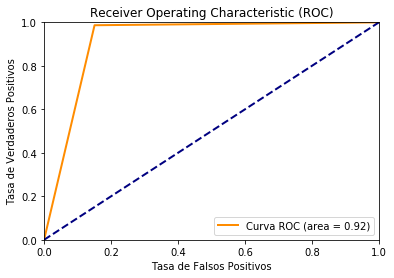

Árboles de decisión | Clasificación
 - Mejor parametrización: {'criterion': 'gini', 'max_depth': 7}
 - Mean Accuracy: 0.96
 - AUC: 0.92
 - Tiempo de entrenamiento: 0:00:02.586233 ⏱
 - Variables de mayor a menor importancia:
    - hr: 73.94%
    - workingday: 13.28%
    - temp: 2.75%
    - atemp: 1.89%
    - season: 1.87%
    - yr: 1.56%
    - weekday: 1.22%
    - mnth: 1.19%
    - hum: 0.76%
    - holiday: 0.75%
    - weathersit: 0.58%
    - windspeed: 0.21%


In [6]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Construcción del modelo para clasificación
dtree_cls = GridSearchCV(
    tree.DecisionTreeClassifier(random_state=1),  # Objeto predictor de clasificación por árboles de decisión
    param_grid={
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de las separaciones
        'max_depth': range(1, 15)          # Número máximo de niveles
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
dtree_cls.fit(df_train[features], df_train[target_cls])
tiempo_dtree_cls = datetime.datetime.now() - inicio

# Predicción
dtree_cls_pred = dtree_cls.predict(df_test[features])

# Determinación de la bondad del ajuste
dtree_mean_accuracy = accuracy_score(df_test[target_cls], dtree_cls_pred)

# Representación de la curva ROC
dtree_roc_auc, dtree_fpr, dtree_tpr = calcular_y_representar_curva_roc(df_test[target_cls], dtree_cls_pred)

print("Árboles de decisión | Clasificación")
print(" - Mejor parametrización:", dtree_cls.best_params_)
print(" - Mean Accuracy: {:.2f}".format(dtree_mean_accuracy))
print(" - AUC: {:.2f}".format(dtree_roc_auc))
print(" - Tiempo de entrenamiento: {} ⏱".format(tiempo_dtree_cls))

# Variables ordenadas por orden de importancia
features_ordenadas_por_importancia = organizar_features_por_importancia(features,
                                                                        dtree_cls.best_estimator_)
print(" - Variables de mayor a menor importancia:")
for feature, importancia in features_ordenadas_por_importancia.items():
    print("    - {}: {:.2f}%".format(feature, importancia))

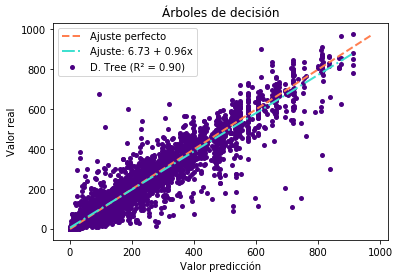

Árboles de decisión | Regresión
 - Mejor parametrización: {'criterion': 'friedman_mse', 'max_depth': 13}
 - R²: 0.90
 - MSE: 3184.40
 - RMSE: 56.43
 - MAE: 32.66
 - Tiempo de entrenamiento: 0:00:36.289100 ⏱
 - Variables de mayor a menor importancia:
    - hr: 62.77%
    - temp: 12.06%
    - yr: 8.15%
    - workingday: 6.09%
    - hum: 2.35%
    - season: 2.29%
    - weathersit: 1.62%
    - mnth: 1.42%
    - atemp: 1.32%
    - weekday: 1.00%
    - windspeed: 0.71%
    - holiday: 0.23%


In [7]:
# Construcción del modelo para regresión
dtree_reg = GridSearchCV(
    tree.DecisionTreeRegressor(random_state=1),  # Objeto predictor de regresión por árboles de decisión
    param_grid={
        'criterion': ['mse', 'friedman_mse', 'mae'],  # Función para medir la calidad de las separaciones
        'max_depth': range(5, 15)                     # Número máximo de niveles
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
dtree_reg.fit(df_train[features], df_train[target_reg])
tiempo_dtree_reg = datetime.datetime.now() - inicio

# Predicción
dtree_reg_pred = dtree_reg.predict(df_test[features])

# Cálculo de errores
dtree_errores = calcular_errores_regresion(df_test[target_reg], dtree_reg_pred)

# Representación de los datos reales frente a los datos predichos por el modelo entrenado
mostrar_grafica_comparacion_predicciones(dtree_reg_pred, df_test[target_reg],
                                         dtree_errores['r2'], 'D. Tree', 'Árboles de decisión',
                                         nombre_imagen='arboles_decision')

print("Árboles de decisión | Regresión")
print(" - Mejor parametrización:", dtree_reg.best_params_)
print(" - R\N{SUPERSCRIPT TWO}: {:.2f}".format(dtree_errores['r2']))
print(" - MSE: {:.2f}".format(dtree_errores['mse']))
print(" - RMSE: {:.2f}".format(dtree_errores['rmse']))
print(" - MAE: {:.2f}".format(dtree_errores['mae']))
print(" - Tiempo de entrenamiento: {} ⏱".format(tiempo_dtree_reg))

# Variables ordenadas por orden de importancia
features_ordenadas_por_importancia = organizar_features_por_importancia(features,
                                                                        dtree_reg.best_estimator_)
print(" - Variables de mayor a menor importancia:")
for feature, importancia in features_ordenadas_por_importancia.items():
    print("    - {}: {:.2f}%".format(feature, importancia))

#### Random Forest

Para generar las predicciones basadas en *Random Forest* se usará el paquete [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), concretamente las clases [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) y [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

El tratamiento realizado para los *random forest* será completamente análogo al realizado en el caso de los [árboles de decisión](#Árboles-de-decisión).

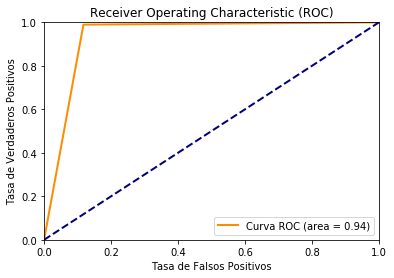

Random Forest | Clasificación
 - Mejor parametrización: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 100}
 - Mean Accuracy: 0.97
 - AUC: 0.94
 - Tiempo de entrenamiento: 0:00:40.309045 ⏱
- Variables de mayor a menor importancia:
    - hr: 68.88%
    - workingday: 7.27%
    - temp: 4.70%
    - atemp: 3.64%
    - hum: 3.03%
    - mnth: 2.28%
    - weekday: 2.18%
    - windspeed: 1.97%
    - yr: 1.87%
    - season: 1.80%
    - weathersit: 1.73%
    - holiday: 0.65%


In [8]:
from sklearn import ensemble

# Construcción del modelo para clasificación
rforest_cls = GridSearchCV(
    ensemble.RandomForestClassifier(random_state=1),  # Objeto predictor de clasificación por árboles de decisión
    param_grid={
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de las separaciones
        'max_features': ['sqrt', None],    # El número de features probadas
        'n_estimators': [10, 100, 150],    # El número de árboles en el bosque
        'max_depth': range(5, 15)          # Número máximo de niveles
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
rforest_cls.fit(df_train[features], df_train[target_cls])
tiempo_rforest_cls = datetime.datetime.now() - inicio

# Predicción
rforest_cls_pred = rforest_cls.predict(df_test[features])

# Determinación de la bondad del ajuste
rforest_mean_accuracy = accuracy_score(df_test[target_cls], rforest_cls_pred)

# Representación de la curva ROC
rforest_roc_auc, rforest_fpr, rforest_tpr = calcular_y_representar_curva_roc(df_test[target_cls], rforest_cls_pred)

print("Random Forest | Clasificación")
print(" - Mejor parametrización:", rforest_cls.best_params_)
print(" - Mean Accuracy: {:.2f}".format(rforest_mean_accuracy))
print(" - AUC: {:.2f}".format(rforest_roc_auc))
print(" - Tiempo de entrenamiento: {} ⏱".format(tiempo_rforest_cls))

# Variables ordenadas por orden de importancia
features_ordenadas_por_importancia = organizar_features_por_importancia(features,
                                                                        rforest_cls.best_estimator_)
print("- Variables de mayor a menor importancia:")
for feature, importancia in features_ordenadas_por_importancia.items():
    print("    - {}: {:.2f}%".format(feature, importancia))

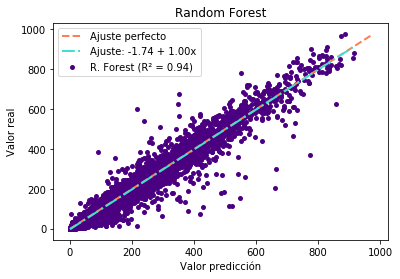

Random Forest | Regresión
 - Mejor parametrización: {'criterion': 'mse', 'max_depth': 19, 'max_features': None, 'n_estimators': 150}
 - R²: 0.94
 - MSE: 1836.82
 - RMSE: 42.86
 - MAE: 25.43
 - Tiempo de entrenamiento: 0:00:45.402377 ⏱
- Variables de mayor a menor importancia:
    - hr: 61.48%
    - temp: 12.08%
    - yr: 8.00%
    - workingday: 5.62%
    - hum: 2.81%
    - atemp: 2.06%
    - season: 1.96%
    - weathersit: 1.76%
    - mnth: 1.70%
    - weekday: 1.26%
    - windspeed: 1.00%
    - holiday: 0.26%


In [9]:
# Construcción del modelo para regresión
rforest_reg = GridSearchCV(
    ensemble.RandomForestRegressor(random_state=13),  # Objeto predictor de regresión por árboles de decisión
    param_grid={
        'criterion': ['mse'],            # Función para medir la calidad de las separaciones
        'max_features': ['sqrt', None],  # El número de features probadas
        'n_estimators': [100, 150],      # El número de árboles en el bosque
        'max_depth': range(15, 25)       # Número máximo de niveles
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
rforest_reg.fit(df_train[features], df_train[target_reg])
tiempo_rforest_reg = datetime.datetime.now() - inicio

# Predicción
rforest_reg_pred = rforest_reg.predict(df_test[features])

# Cálculo de errores
rforest_errores = calcular_errores_regresion(df_test[target_reg], rforest_reg_pred)

# Representación de los datos reales frente a los datos predichos por el modelo entrenado
mostrar_grafica_comparacion_predicciones(rforest_reg_pred, df_test[target_reg],
                                         rforest_errores['r2'], 'R. Forest', 'Random Forest',
                                         nombre_imagen='random_forest')

print("Random Forest | Regresión")
print(" - Mejor parametrización:", rforest_reg.best_params_)
print(" - R\N{SUPERSCRIPT TWO}: {:.2f}".format(rforest_errores['r2']))
print(" - MSE: {:.2f}".format(rforest_errores['mse']))
print(" - RMSE: {:.2f}".format(rforest_errores['rmse']))
print(" - MAE: {:.2f}".format(rforest_errores['mae']))
print(" - Tiempo de entrenamiento: {} ⏱".format(tiempo_rforest_reg))

# Variables ordenadas por orden de importancia
features_ordenadas_por_importancia = organizar_features_por_importancia(features,
                                                                        rforest_reg.best_estimator_)
print("- Variables de mayor a menor importancia:")
for feature, importancia in features_ordenadas_por_importancia.items():
    print("    - {}: {:.2f}%".format(feature, importancia))

### Conclusiones

La primera conclusión de los resultados es que ambos modelos predictivos, tanto para clasificación como para predicción, arrojan resultados sorprendentemente buenos sin apenas esfuerzo a la hora de seleccionar los parámetros de los modelos. Esto es una muestra de la potencia de estos modelos predictores.

Si se comparan los dos modelos de clasificación, puede verse que en el caso de *Random Forest* los resultados son ligeramente mejores como demuestran tanto la métrica *AUC* como la *Mean Accuracy*:

|Métrica|Decision Tree|Random Forest|
|:----:|:-----------:|:-----------:|
|AUC|`0.92`|**`0.94`**|
|Mean Accuracy|`0.96`|**`0.97`**|

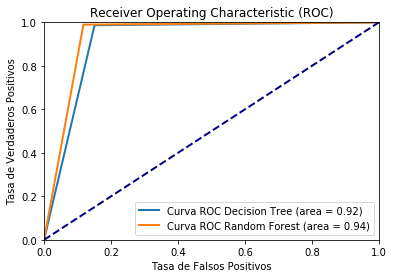

In [10]:
# Representación de las dos curvas ROC juntas
fpr = { 'Decision Tree': dtree_fpr, 'Random Forest': rforest_fpr }
tpr = { 'Decision Tree': dtree_tpr, 'Random Forest': rforest_tpr }
roc_auc = { 'Decision Tree': dtree_roc_auc, 'Random Forest': rforest_roc_auc }

representar_curva_roc(fpr, tpr, roc_auc, nombre_imagen='area_under_curve')

Atendiendo ahora a los resultados de los modelos de regresión, de nuevo el modelo predictor de *Ranfom Forest* obtiene mejores resultados que el basado en *Árboles de Decisión* y en este caso la diferencia se hace más visible como se muestra en la siguiente tabla:

|Métrica|Decision Tree|Random Forest|
|:----:|:-----------:|:-----------:|
|$R^{2}$|`0.90`|**`0.94`**|
|MAE|`32.66`|**`25.43`**|
|RMSE|`56.43`|**`42.86`**|
|MSE|`3184.40`|**`1836.82`**|

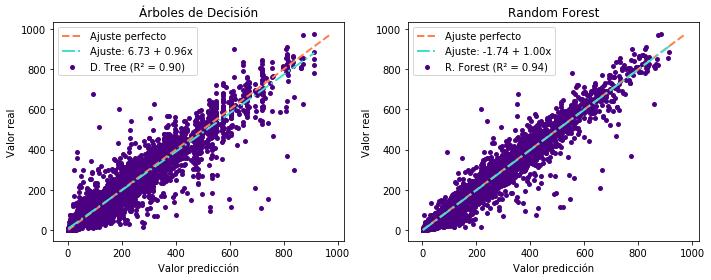

In [11]:
plt.subplots(1,2, figsize=(10,4), sharey=True)
plt.subplot(1, 2, 1)
mostrar_grafica_comparacion_predicciones(dtree_reg_pred, df_test[target_reg], dtree_errores['r2'],
                                         'D. Tree', 'Árboles de Decisión', mostrar=False)

plt.subplot(1, 2, 2)
mostrar_grafica_comparacion_predicciones(rforest_reg_pred, df_test[target_reg], rforest_errores['r2'],
                                         'R. Forest', 'Random Forest', mostrar=False)

plt.tight_layout()
plt.show()

En vista de estos resultados cabe indicar que el modelo de **Random Forest** genera mejores predicciones que el modelo de *Árboles de Decisión*.

Además, viendo las gráficas superiores donde se comparan las predicciones de los modelos de regresión puede observarse que la recta de ajuste del modelo de *Árboles de Decisión* tiene una cierta tendencia a sobreestimar las predicciones a medida que el número de ventas aumenta dado que la pendiente de la recta de ajuste es ligeramente inferior a `1`, lo que quiere decir que se ha dado un valor de predicción más alto que el de la observación. Y una ordenada en el origen relativamente alta que introduce una desviación sistemática en las predicciones.

Sin embargo, el ajuste del modelo de *Random Forest* no tiene ninguna tendencia a desviarse a medida que el número de ventas crece, y la desviación sistemática (ordenada en el origen) es más pequeña que en el otro modelo.

Si se le puede poner una pega al modelo de *Random Forest* en comparación con el de *Árboles de decisión* es que el primero requiere de tiempos mayores de entrenamiento, lo que puede suponer un hándicap con *datasets* muy grandes.

|Modelo|Tiempo Clasificación (secs)|Tiempo Regresión (secs)|
|:----:|:-------------------------:|:---------------------:|
|Árboles de Decisión|**`2.596526`**|**`27.940146`**|
|Random Forest|`40.622257`|`45.154214`|

Por último, es interesante ver la importancia o peso que asignan cada modelo a las variables. En todos los casos la feature `hr` es la que mayor peso recibe, con mucha diferencia, `61-74%`, dependiendo del modelo. Mientras que la segunda feature con mayor peso difiere en función del tipo de predicción. Los modelos de clasificación consideran que la feature `workingday` es la segunda variable más decisiva, mientras que los modelos de regresión identifican la variable `temp` como la segunda más importante.

### Apéndices

#### Estudio de relación de variables

Antes de comenzar con el entrenamiento del modelo y generar predicciones con él, es conveniente hacer un estudio más profundo de las variables predictoras que permita intuir cómo afectarán estas variables a los resultados.

##### Variables de calendario

Del siguiente gráfico en el que se muestra la relación entre las variables de calendario pueden sacarse algunas conclusiones interesantes:

- *Gráfico(1,2)* | **cnt vs mnth** : Las ventas son más bajas en invierno
- *Gráfico(1,3)* | **cnt vs hr** : Las ventas son más altas a primera hora de la mañana y por la tarde
- *Gráfico(1,5)* | **cnt vs weekday** : Las ventas son más bajas los fines de semana
- *Gráfico(2,2)* | **mnth vs mnth** : Se tienen datos uniformemente distribuidos en todos los meses por lo que no debería haber sesgos basados en esta variable
- *Gráfico(3,3)* | **hr vs hr** : Igual que con los meses, también se observa uniformidad en el número de registros por horas
- *Gráfico(4,4)* | **holiday vs holiday** : Hay muchas menos fiestas que días laborales
- *Gráfico(5,5)* | **weekday vs weekday** : El muestreo de días también es uniforme

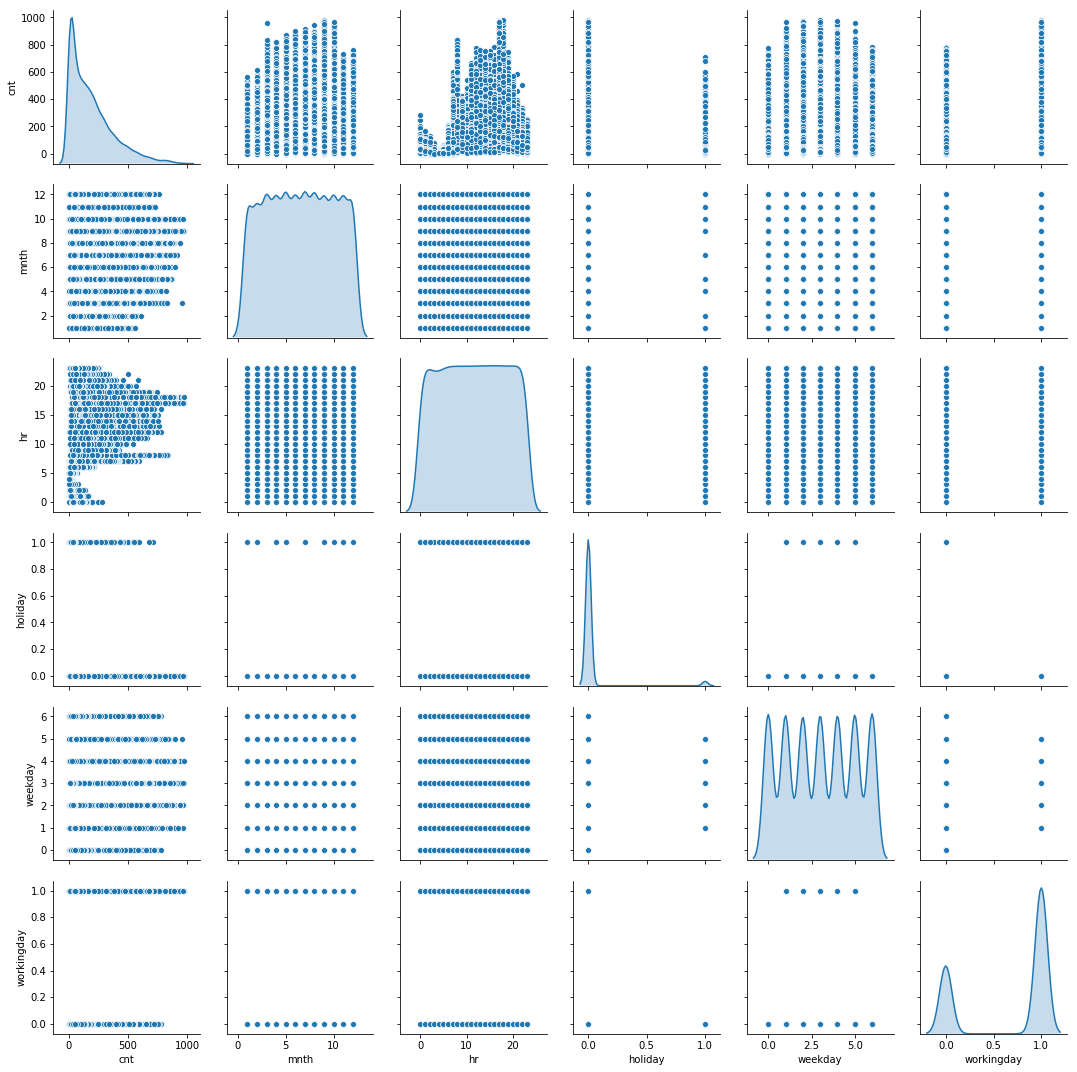

In [12]:
dibujar_correlacion_de_variables(df, variables=['cnt', 'mnth', 'hr', 'holiday', 'weekday', 'workingday'])

##### Variables de meteorología

Observando las siguientes gráficas lo primero que salta a la vista es que cuando hace mal tiempo `weathersit: 4` las ventas descienden mucho.

El resto de variables meteorológicas tienen un comportamiento bastante homogéneo en relación al número de ventas de bicicletas.

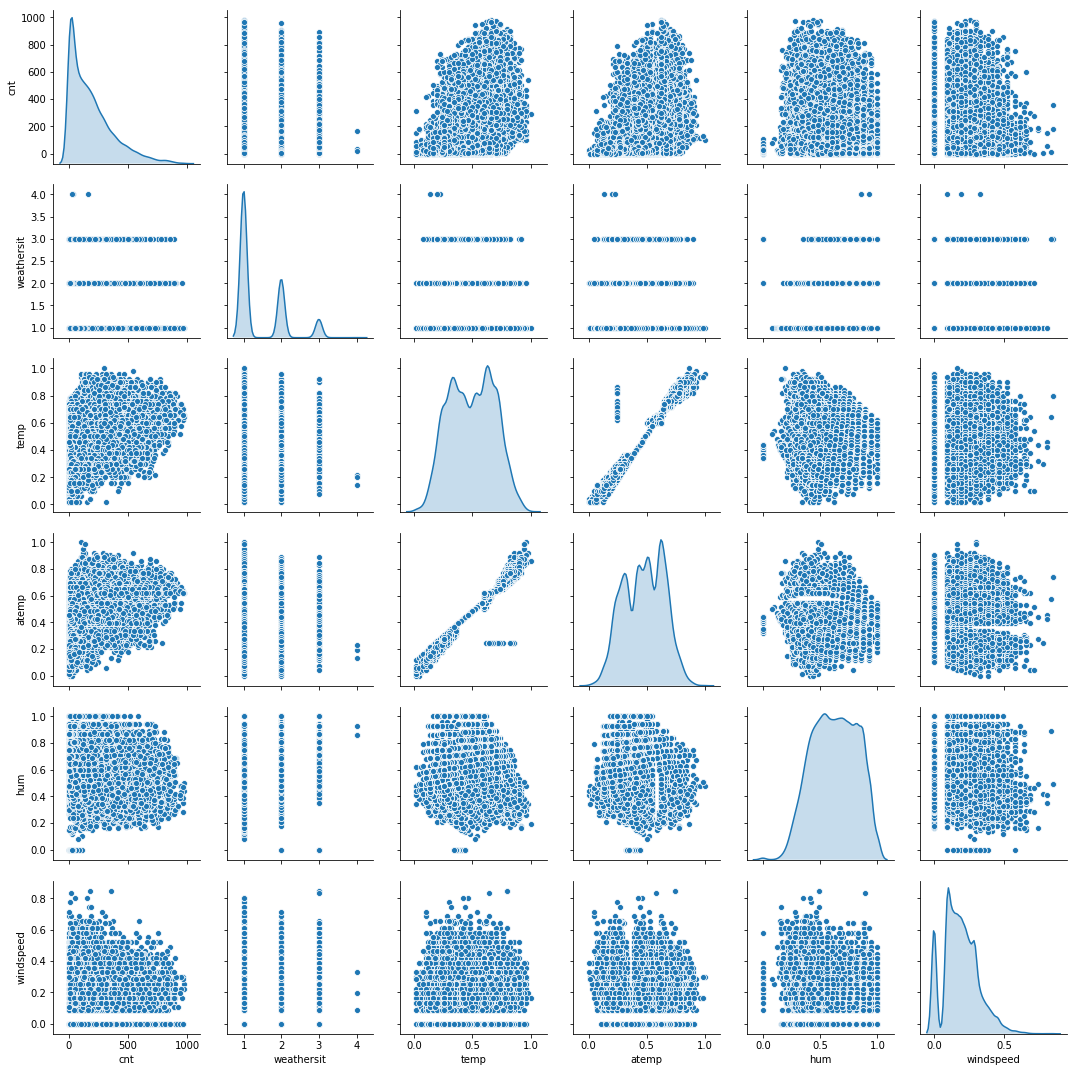

In [13]:
dibujar_correlacion_de_variables(df, variables=['cnt', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'])

##### Clasificación por regresión

Este apéndice pretende estudiar las predicciones de ventas altas o bajas a partir de las predicciones generadas por regresión comparándolas con las predicciones obtenidas por clasificación.

De partida cabe esperar que los resultados de ventas altas derivados de los modelos de regresión sean peores que los obtenidos directamente por modelos de clasificación, dado que los segundos han sido entrenados específicamente para ser precisos en dicha predicción.

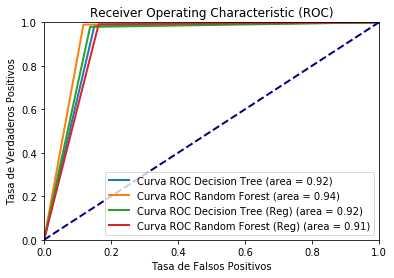

In [14]:
# Predicciones de ventas altas basadas en las predicciones de regresión por árboles de decisión
dtree_reg_cls_pred = dtree_reg_pred > limite_ventas_altas
dtree_roc_auc_, dtree_fpr_, dtree_tpr_ = calcular_y_representar_curva_roc(df_test[target_cls],
                                                                          dtree_reg_cls_pred,
                                                                          mostrar=False)

# Predicciones de ventas altas basadas en las predicciones de regresión por random forest
rforest_reg_cls_pred = rforest_reg_pred > limite_ventas_altas
rforest_roc_auc_, rforest_fpr_, rforest_tpr_ = calcular_y_representar_curva_roc(df_test[target_cls],
                                                                                rforest_reg_cls_pred,
                                                                                mostrar=False)

# Representación de todas las curvas ROC juntas
fpr_ = {**fpr, 'Decision Tree (Reg)': dtree_fpr_, 'Random Forest (Reg)': rforest_fpr_}
tpr_ = {**tpr, 'Decision Tree (Reg)': dtree_tpr_, 'Random Forest (Reg)': rforest_tpr_}
roc_auc_ = {**roc_auc, 'Decision Tree (Reg)': dtree_roc_auc_, 'Random Forest (Reg)': rforest_roc_auc_}

representar_curva_roc(fpr_, tpr_, roc_auc_)

Es interesante ver que en el caso de los *Árboles de Decisión* la métrica AUC se ha conservado dando la misma precisión en la predicción, mientras que en el caso de los *Random Forest* la predicción ha empeorado con este método con respecto a la clasificación directa con el modelo de clasificación.

#### Generación de PDFs

La siguiente celda genera la estructura de los árboles de decisión y los guarda en archivos PDF.

In [15]:
import importlib.util
import sys
from pathlib import Path

paquete_requerido = 'pydotplus'
if not importlib.util.find_spec(paquete_requerido):
    raise Exception("Se requiere el paquete {} para ejecutar esta celda".format(paquete_requerido))

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

def representar_arbol(tree, features, nombre_archivo, formato='pdf'):
    dot_data = StringIO()
    export_graphviz(tree,
                    out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names = features,
                    class_names=['0','1'])
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write(nombre_archivo, format=formato)
    Image(graph.create(format=formato))
    
# Generación de PDF con la estructura de decisión del árbol del modelo de clasificación
archivo_clasificacion = Path('decision_tree_clasificacion.pdf')
representar_arbol(dtree_cls.best_estimator_, features, str(archivo_clasificacion), formato='pdf')
if archivo_clasificacion.is_file():
    print("Se ha creado el archivo '{}' con la representación del árbol de clasificación.".format(str(archivo_clasificacion)))
else:
    eprint("No se ha podido crear la representación del modelo de clasificación.")

# Generación de PDF con la estructura de decisión del árbol del modelo de regresión
archivo_regresion = Path('decision_tree_regression.pdf')
representar_arbol(dtree_reg.best_estimator_, features, str(archivo_regresion), formato='pdf')
if archivo_clasificacion.is_file():
    print("Se ha creado el archivo '{}' con la representación del árbol de regresión.".format(str(archivo_clasificacion)))
else:
    eprint("No se ha podido crear la representación del modelo de regresión.")

Se ha creado el archivo 'decision_tree_clasificacion.pdf' con la representación del árbol de clasificación.
Se ha creado el archivo 'decision_tree_clasificacion.pdf' con la representación del árbol de regresión.
